# Multi Task Model

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Tensorflow imports
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.applications import MobileNet

from loadData import createDataset

## Model parameters

In [2]:
# Log parameters
model_name = 'mtm_classification_cascade'
savedModelPath = f'../../log/saved_models/{model_name}'
tb_log_dir = f'../../log/tensorboard/{model_name}'
cp_filepath = f'../../log/cps/{model_name}/'

if not os.path.exists(cp_filepath):
    os.makedirs(cp_filepath)

cp_filepath += 'latest_weights.h5'

# Dynamic hyperparameters
learningRate = 0.001
doDataAugmentation = True
doFineTuning = True
dropoutRate = 0.25
width_multiplier = 1
depth_multiplier = 1

# Training parameters
batch_size = 32
epochs = 5

## Model callbacks

In [3]:
callbacks = [
    # Checkpoint callback                    
    keras.callbacks.ModelCheckpoint(
                    filepath=cp_filepath, 
                    verbose=1, 
                    save_weights_only=True),

    # Tensorboard callback
    keras.callbacks.TensorBoard(log_dir=tb_log_dir, histogram_freq=1),

    # Early Stopping callback
    # keras.callbacks.EarlyStopping(
    #                 monitor="val_loss",
    #                 patience=2,
    #                 verbose=1)
]

## Data parameters

In [4]:
image_height = 160
image_width = 160

use_age_groups = False
num_age_classes = 8 if use_age_groups else 122

## Data Augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomBrightness(0.2),
    ]
)

## Creating the training datasets

In [6]:
x, y_face, y_mask, y_age = createDataset('../../data/m3/training', (image_height, image_width), use_age_groups=use_age_groups)

## Creating the test dataset

In [7]:
# test_ds = createDataset('../../data/m3/training', batch_size, 0)

## Load the ResNet model

In [8]:
# Loading either the MobileNet architecture model or the previously saved model, and freeze it for transfer learning
mobilenet = MobileNet(
                input_shape=(image_height, image_width, 3), # Optional shape tuple, only to be specified if include_top is False
                alpha=width_multiplier, # Controls the width of the network. (Width multiplier)
                depth_multiplier=depth_multiplier, # Depth multiplier for depthwise convolution. (Resolution multiplier)
                dropout=dropoutRate, # Dropout rate. Default to 0.001.
                weights="imagenet",
                input_tensor=None,
                pooling='avg', # Optional pooling mode for feature extraction when include_top is False. (None, avg, max)
                include_top=False
                )
           
# Freeze the base model
mobilenet.trainable = False

inputs = keras.Input(shape=(image_height, image_width, 3))

# Data Augmentation on input
if(doDataAugmentation):
    inputs = data_augmentation(inputs)

# Running base model in inference mode
base_model = mobilenet(inputs, training=False)

## Creating Task 1 (Face Detection) Top Model

In [9]:
# Add Dense layer
face_head = tf.keras.layers.Dense(256, activation='relu')(base_model)
face_head = tf.keras.layers.Dense(128, activation='relu')(face_head)

# Final layer for binary classification
face_outputs = keras.layers.Dense(2, activation='softmax', name='face_output')(face_head)

In [10]:
multiply_layer = keras.layers.Multiply()([base_model, face_outputs])
multiply_layer = keras.layers.Dense(512, activation='relu')(multiply_layer)

## Creating Task 2 (Mask Detection) Top Model

In [11]:
# Add Dense layer
mask_head = tf.keras.layers.Dense(128, activation='relu')(multiply_layer)
mask_head = tf.keras.layers.Dense(64, activation='relu')(mask_head)

# Final layer for binary classification
mask_outputs = keras.layers.Dense(2, activation='softmax', name='mask_output')(mask_head)

## Creating Task 3 (Age Prediction) Top Model

In [12]:
# Add Dense layer
age_head = tf.keras.layers.Dense(256, activation='relu')(multiply_layer)
age_head = tf.keras.layers.Dense(128, activation='relu')(age_head)
age_head = tf.keras.layers.Dense(64, activation='relu')(age_head)

# Final layer for binary classification
age_outputs = keras.layers.Dense(num_age_classes, activation='softmax', name='age_output')(age_head)

In [13]:
age_class_weights = np.ones((batch_size,num_age_classes), dtype=np.float32)
age_class_weights[:, num_age_classes-1] = 0.0 # Last class will be ignored (invalid data)

def WeightedCategoricalCrossentropy(y_true, y_pred):
    nb_cl = len(age_class_weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    y_pred_max_mat = tf.where(y_pred_max_mat, 1.0, 0.0)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (age_class_weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

## Creating and compiling the final model

In [14]:

model = keras.Model(inputs, [face_outputs, mask_outputs, age_outputs])
#keras.utils.plot_model(model)

# Using a joint loss function for the three tasks:
# [ Loss = gamma * Loss_task1 + gamma * Loss_task2 + gamma * Loss_task3 ]
# Because every task is dependant on every other task, the model receives the loss of every task when gamma > 0

gamma = 1

model.compile(
      optimizer=keras.optimizers.Adam(), # Learning Rate?
            loss={
                  'face_output': 'categorical_crossentropy', 
                  'mask_output': 'categorical_crossentropy',
                  'age_output': 'categorical_crossentropy'
                  },
            loss_weights={
                  'face_output': 0.33 * gamma,
                  'mask_output': 0.33 * gamma,
                  'age_output': 0.33 * gamma
                  }, 
            metrics={
                  'face_output': 'categorical_accuracy', 
                  'mask_output': 'categorical_accuracy',
                  'age_output': 'categorical_accuracy'
                  },
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenet_1.00_160 (Functional  (None, 1024)        3228864     ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 dense (Dense)                  (None, 256)          262400      ['mobilenet_1.00_160[1][0]']     
                                                                                              

## Training the model with the dataset

In [15]:
history = model.fit(
            x,
            y={'face_output': y_face, 
             'mask_output': y_mask,
             'age_output': y_age},
            batch_size=batch_size,
            epochs=epochs, 
            callbacks=callbacks,
            validation_split=0.2,
            shuffle=True
        )

Epoch 1/5
512/512 [==============================] - ETA: 0s - loss: 0.7919 - face_output_loss: 0.0400 - mask_output_loss: 0.0165 - age_output_loss: 2.3431 - face_output_binary_accuracy: 0.9883 - mask_output_binary_accuracy: 0.9939 - age_output_categorical_accuracy: 0.4686
Epoch 1: saving model to ../../log/cps/mtm_classification_cascade\latest_weights.h5
512/512 [==============================] - 104s 199ms/step - loss: 0.7919 - face_output_loss: 0.0400 - mask_output_loss: 0.0165 - age_output_loss: 2.3431 - face_output_binary_accuracy: 0.9883 - mask_output_binary_accuracy: 0.9939 - age_output_categorical_accuracy: 0.4686 - val_loss: 0.0014 - val_face_output_loss: 0.0013 - val_mask_output_loss: 3.5156e-04 - val_age_output_loss: 0.0026 - val_face_output_binary_accuracy: 0.9998 - val_mask_output_binary_accuracy: 1.0000 - val_age_output_categorical_accuracy: 1.0000
Epoch 2/5
512/512 [==============================] - ETA: 0s - loss: 0.7042 - face_output_loss: 0.0069 - mask_output_loss: 0.

## Fine tuning

In [ ]:
if doFineTuning:
      model_name = model_name + '_ft'
      mobilenet.trainable = True
      model.summary()

      model.compile(
            optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
            loss={
                  'face_output': keras.losses.BinaryCrossentropy(), 
                  'mask_output': keras.losses.BinaryCrossentropy(),
                  'age_output': keras.losses.SparseCategoricalCrossentropy(ignore_class=-1)
                  },
            loss_weights={
                  'face_output': gamma, 
                  'mask_output': gamma,
                  'age_output': gamma
                  }, 
                  metrics=['accuracy']
      )

      model.fit(training_ds, epochs=epochs)

## Save the model

In [ ]:
model.save(savedModelPath)

## Test model with test dataset

In [ ]:
results = model.evaluate(test_ds)

print(f'Loss: {results[0]}; Accuracy: {results[1]}')

## Predict new images

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'Face: 8.33% | Mask: 0.75% | Age: 114')

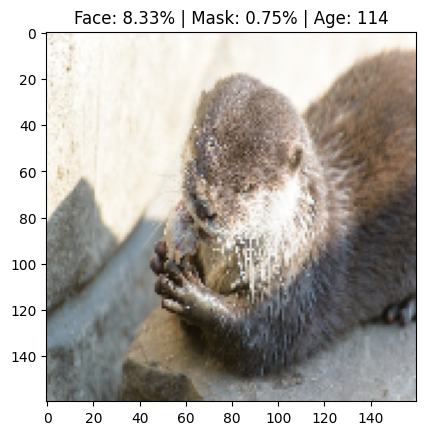

In [29]:
# https://www.tensorflow.org/tutorials/images/classification

img = tf.keras.utils.load_img(
    '../../data/m3/training/noFace/0_0_-1_600013.jpg', target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array_batch = tf.expand_dims(img_array, 0) # Create a batch

preds = model.predict(img_array_batch)
age_output_indexes = np.array([i for i in range(0, 122)])

face_pred_percent = preds[0][0][0]*100
mask_pred_percent = preds[1][0][0]*100
age_preds = preds[2][0]
age_pred = np.argmax(age_preds)
avg_age_pred = np.sum(age_preds * age_output_indexes)

ax = plt.subplot(1, 1, 1)
plt.imshow(img)
plt.title("Face: {:.2f}% | Mask: {:.2f}% | Age: {:.0f}".format(face_pred_percent, mask_pred_percent, avg_age_pred))